# AI Fitness Coach - Agente de IA para Criação de Planilhas de Treino de Musculação

Este projeto utiliza LangGraph para criar um agente inteligente capaz de gerar planos de treino personalizados.

## Arquitetura do Sistema

- Coleta e validação de dados do usuário
- Ferramenta de busca na web (Tavily Search)
- Ferramenta de cálculos matemáticos (IMC, gasto calórico)
- RAG com base de conhecimento sobre exercícios e treinos
- Geração de plano de treino completo com 12 treinos

## 1 - Instalação e Importação de Bibliotecas

In [123]:
from dotenv import find_dotenv, load_dotenv
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI  # ADICIONADO: OpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_core.documents import Document
from langchain_core.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict
from typing import Annotated
from pinecone import Pinecone, ServerlessSpec
from IPython.display import display, Markdown, Image
import ipywidgets as widgets
import os
import time
import math

## 2 - Configuração do Modelo LLM

In [147]:
load_dotenv(find_dotenv())

def load_llm(id_model, temperature, provider="openai"):
    """
    Carrega o modelo LLM - suporta OpenAI e Groq
    
    Args:
        id_model: Nome do modelo
        temperature: Controle de criatividade (0.0 a 1.0)
        provider: "openai" ou "groq"
    """
    if provider == "openai":
        llm = ChatOpenAI(
            model=id_model,
            temperature=temperature,
            max_tokens=None,
            timeout=None,
            max_retries=2,
        )
    else:  # groq
        llm = ChatGroq(
            model=id_model,
            temperature=temperature,
            max_tokens=None,
            timeout=None,
            max_retries=2,
        )
    return llm

# CONFIGURAÇÃO: Mude aqui para trocar entre OpenAI e Groq
provider = "groq"  # ✅ USANDO GROQ (gratuito e funcional)

# Modelos recomendados:
# OpenAI: "gpt-4o-mini", "gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"
# Groq: "llama-3.3-70b-versatile", "llama-3.1-8b-instant"

if provider == "openai":
    id_model = "gpt-4o"  
else:
    id_model = "llama-3.1-8b-instant"  # Mais leve para evitar erro 413

temperature = 0.7

llm = load_llm(id_model, temperature, provider)
print(f"✅ Modelo carregado: {id_model} ({provider.upper()})")
print(f"   Temperature: {temperature}")

✅ Modelo carregado: gpt-4o (OPENAI)
   Temperature: 0.7


### 💡 Modelos Disponíveis

**OpenAI (Recomendado - sem erro 413):**
- `gpt-4o-mini` - Mais rápido e econômico ⚡ **(RECOMENDADO)**
- `gpt-4o` - Mais poderoso e recente
- `gpt-4-turbo` - Equilíbrio custo/desempenho
- `gpt-3.5-turbo` - Mais barato

**Groq (Gratuito mas com limites):**
- `llama-3.3-70b-versatile` - Mais poderoso (pode dar erro 413)
- `llama-3.1-8b-instant` - Mais rápido

**Para trocar:** Modifique as variáveis `provider` e `id_model` na célula acima.

## 3 - Criação da Base de Conhecimento (RAG)

### 3.1 - Base de dados sobre exercícios e treinamento

In [125]:
knowledge_base = """
# Princípios do Treinamento de Musculação

## Hipertrofia Muscular
A hipertrofia é o aumento do tamanho das fibras musculares. Para maximizar a hipertrofia:
- Volume: 3-5 séries por exercício
- Repetições: 8-12 repetições por série
- Descanso: 60-90 segundos entre séries
- Frequência: Treinar cada grupo muscular 2 vezes por semana
- Progressão: Aumentar carga gradualmente

## Força Muscular
Treinamento focado em ganho de força máxima:
- Volume: 3-5 séries por exercício
- Repetições: 3-6 repetições por série
- Descanso: 2-5 minutos entre séries
- Intensidade: 85-95% de 1RM
- Exercícios compostos são prioritários

## Emagrecimento
Treino para perda de gordura corporal:
- Volume: 3-4 séries por exercício
- Repetições: 12-15 repetições por série
- Descanso: 30-60 segundos entre séries
- Circuitos e superséries são eficientes
- Combinar com exercícios aeróbicos

## Condicionamento Físico
Melhora da capacidade cardiovascular e resistência:
- Volume: 2-3 séries por exercício
- Repetições: 15-20 repetições por série
- Descanso: 30-45 segundos entre séries
- Exercícios funcionais e compostos
- Alta intensidade e menor carga

# Exercícios por Grupo Muscular

## Peito (Peitoral)
- Supino reto com barra: Peitoral maior, tríceps, deltoides anterior
- Supino inclinado com halteres: Peitoral superior, deltoides
- Crucifixo: Isolamento do peitoral
- Flexão de braços: Peitoral, tríceps, core
- Supino declinado: Peitoral inferior
- Crossover: Definição e isolamento do peitoral

## Costas (Dorsal)
- Barra fixa: Grande dorsal, bíceps
- Remada curvada: Trapézio médio, romboides, grande dorsal
- Puxada frontal: Grande dorsal, bíceps
- Remada unilateral: Dorsal, estabilização do core
- Levantamento terra: Eretores da espinha, glúteos, posterior de coxa
- Pulldown: Grande dorsal, bíceps

## Pernas (Membros Inferiores)
- Agachamento livre: Quadríceps, glúteos, posterior
- Leg press: Quadríceps, glúteos
- Cadeira extensora: Isolamento do quadríceps
- Mesa flexora: Posterior de coxa
- Stiff: Posterior de coxa, glúteos
- Avanço (afundo): Quadríceps, glúteos, equilíbrio
- Panturrilha em pé: Gastrocnêmio
- Panturrilha sentado: Sóleo

## Ombros (Deltoides)
- Desenvolvimento com barra: Deltoides anterior e médio
- Desenvolvimento com halteres: Deltoides completo, estabilização
- Elevação lateral: Deltoides médio
- Elevação frontal: Deltoides anterior
- Crucifixo invertido: Deltoides posterior
- Remada alta: Deltoides, trapézio

## Bíceps
- Rosca direta com barra: Bíceps braquial
- Rosca alternada com halteres: Bíceps, braquial
- Rosca martelo: Braquial, braquiorradial
- Rosca concentrada: Isolamento do bíceps
- Rosca scott: Bíceps braquial (porção curta)

## Tríceps
- Tríceps testa: Cabeça longa do tríceps
- Tríceps corda: Tríceps completo
- Mergulho: Tríceps, peitoral inferior
- Tríceps coice: Isolamento do tríceps
- Supino fechado: Tríceps, peitoral

## Abdômen
- Abdominal crunch: Reto abdominal superior
- Elevação de pernas: Reto abdominal inferior
- Prancha: Core completo, estabilização
- Abdominal bicicleta: Oblíquos, reto abdominal
- Prancha lateral: Oblíquos

# Divisões de Treino por Periodicidade

## 2 dias por semana - Treino AB
- Treino A: Corpo superior (peito, costas, ombros, braços)
- Treino B: Corpo inferior (pernas completo, abdômen)

## 3 dias por semana - Treino ABC
- Treino A: Peito, ombros e tríceps
- Treino B: Costas e bíceps
- Treino C: Pernas e abdômen

## 4 dias por semana - Treino ABCD
- Treino A: Peito e tríceps
- Treino B: Costas e bíceps
- Treino C: Pernas (quadríceps e panturrilha)
- Treino D: Ombros e abdômen

## 5 dias por semana - Treino ABCDE
- Treino A: Peito
- Treino B: Costas
- Treino C: Pernas (quadríceps e panturrilha)
- Treino D: Ombros e abdômen
- Treino E: Bíceps, tríceps e posterior de coxa

## 6 dias por semana - Treino ABCDEF
- Treino A: Peito
- Treino B: Costas
- Treino C: Pernas (quadríceps e panturrilha)
- Treino D: Ombros
- Treino E: Bíceps e tríceps
- Treino F: Posterior de coxa e abdômen

# Dicas Importantes de Execução

## Aquecimento
- 5-10 minutos de atividade cardiovascular leve
- Mobilidade articular específica
- Séries de aquecimento com carga progressiva

## Técnica de Execução
- Controlar a fase concêntrica e excêntrica
- Manter amplitude completa de movimento
- Respiração adequada: expirar no esforço
- Evitar compensações e trapaças

## Progressão
- Aumentar carga quando conseguir realizar todas as séries e repetições com boa técnica
- Incrementos de 2,5 a 5% na carga
- Variar exercícios a cada 4-6 semanas

## Recuperação
- Descanso adequado entre treinos do mesmo grupo muscular (48-72h)
- Sono de qualidade (7-9 horas)
- Nutrição adequada para os objetivos
- Hidratação constante
"""

print("Base de conhecimento criada com sucesso!")

Base de conhecimento criada com sucesso!


### 3.2 - Configuração do modelo de embedding

In [126]:
# Usando modelo mais leve - all-MiniLM-L6-v2 (apenas ~80MB vs 2.2GB do bge-m3)
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model,
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)
print(f"Modelo de embedding carregado: {embedding_model}")
print(f"Dimensão dos vetores: 384 (vs 1024 do bge-m3)")
print("Modelo leve e eficiente para o projeto!")

Modelo de embedding carregado: sentence-transformers/all-MiniLM-L6-v2
Dimensão dos vetores: 384 (vs 1024 do bge-m3)
Modelo leve e eficiente para o projeto!


### 3.3 - Configuração do Pinecone

In [127]:
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

def create_index(pc, index_name, dimension=384):  # Alterado de 1024 para 384
    existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
    if index_name in existing_indexes:
        print(f"Deletando o indice existente '{index_name}'...")
        pc.delete_index(index_name)
        time.sleep(1)

    pc.create_index(
        name=index_name,
        metric="cosine",
        dimension=dimension,
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    
    while not pc.describe_index(index_name).status["ready"]:
        print("Aguardando o indice ficar pronto...")
        time.sleep(1)

    index = pc.Index(index_name)
    return index

print("Pinecone configurado com 384 dimensões (all-MiniLM-L6-v2)!")

Pinecone configurado com 384 dimensões (all-MiniLM-L6-v2)!


### 3.4 - Criação dos documentos e vetorização

In [128]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def split_chunks(documents, chunk_size=1000, chunk_overlap=200):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Chunks gerados: {len(chunks)}")
    return chunks

# Criar documentos a partir da base de conhecimento
docs = [Document(page_content=knowledge_base)]
chunks = split_chunks(docs, chunk_size=800, chunk_overlap=100)

print(f"Total de chunks criados: {len(chunks)}")

Chunks gerados: 8
Total de chunks criados: 8


### 3.5 - Criação do índice e retriever

In [129]:
index_name = "fitness-coach"

def config_retriever(pc, index_name, docs, embeddings):
    create_index(pc, index_name)
    vectorstore = PineconeVectorStore.from_documents(
        documents=docs,
        embedding=embeddings,
        index_name=index_name,
    )
    return vectorstore.as_retriever(
        search_type='mmr',
        search_kwargs={'k': 5, 'fetch_k': 10}
    )

retriever = config_retriever(pc, index_name, chunks, embeddings)
print("Retriever configurado com sucesso!")

Deletando o indice existente 'fitness-coach'...
Retriever configurado com sucesso!
Retriever configurado com sucesso!


### 3.6 - Testando o retriever

In [131]:
# Teste do retriever
test_results = retriever.invoke("exercícios para hipertrofia de peito")
print(f"Documentos recuperados: {len(test_results)}")
print("\nPrimeiro resultado:")
print(test_results[0].page_content[:300] + "...")

Documentos recuperados: 5

Primeiro resultado:
# Princípios do Treinamento de Musculação

## Hipertrofia Muscular
A hipertrofia é o aumento do tamanho das fibras musculares. Para maximizar a hipertrofia:
- Volume: 3-5 séries por exercício
- Repetições: 8-12 repetições por série
- Descanso: 60-90 segundos entre séries
- Frequência: Treinar cada g...


## 4 - Ferramentas (Tools)

### 4.1 - Ferramenta de Cálculo Matemático

In [132]:
@tool
def calculator_tool(expression: str) -> str:
    """Realiza cálculos matemáticos. Use para calcular IMC, gasto calórico e outras operações matemáticas.
    Exemplos: '70 / (1.75 ** 2)' para IMC, '88.36 + (13.4 * 70) - (4.8 * 25)' para TMB."""
    try:
        import numexpr
        local_dict = {"pi": math.pi, "e": math.e}
        result = numexpr.evaluate(
            expression.strip(),
            global_dict={},
            local_dict=local_dict,
        )
        return str(result)
    except Exception as e:
        return f"Erro ao calcular: {str(e)}"

@tool
def fitness_calculator(idade: int, peso: float, altura: float, sexo: str, objetivo: str) -> str:
    """Calcula IMC e gasto calórico aproximado baseado nos dados do usuário.
    Parâmetros: idade (anos), peso (kg), altura (metros), sexo ('M' ou 'F'), objetivo (hipertrofia/emagrecimento/força/condicionamento).
    Retorna informações sobre IMC e estimativa de gasto calórico por treino."""
    try:
        # Calcular IMC
        imc = peso / (altura ** 2)
        
        # Classificação do IMC
        if imc < 18.5:
            classificacao_imc = "Abaixo do peso"
        elif imc < 25:
            classificacao_imc = "Peso normal"
        elif imc < 30:
            classificacao_imc = "Sobrepeso"
        else:
            classificacao_imc = "Obesidade"
        
        # Calcular TMB (Taxa Metabólica Basal) usando equação de Harris-Benedict
        if sexo.upper() == 'M':
            tmb = 88.36 + (13.4 * peso) + (4.8 * altura * 100) - (5.7 * idade)
        else:
            tmb = 447.6 + (9.2 * peso) + (3.1 * altura * 100) - (4.3 * idade)
        
        # Estimar gasto calórico por treino baseado no objetivo
        if objetivo.lower() == "hipertrofia":
            calorias_treino = 300 + (peso * 4)
            intensidade = "Moderada a alta"
        elif objetivo.lower() == "emagrecimento":
            calorias_treino = 400 + (peso * 5)
            intensidade = "Alta"
        elif objetivo.lower() == "força":
            calorias_treino = 250 + (peso * 3.5)
            intensidade = "Alta intensidade, menor volume"
        else:  # condicionamento
            calorias_treino = 350 + (peso * 4.5)
            intensidade = "Moderada a alta"
        
        resultado = f"""
        Análise Física:
        - IMC: {imc:.1f} ({classificacao_imc})
        - Taxa Metabólica Basal: {tmb:.0f} kcal/dia
        - Gasto calórico estimado por treino: {calorias_treino:.0f} kcal
        - Intensidade recomendada: {intensidade}
        
        Recomendações:
        - Hidratação: {(peso * 35):.0f}ml de água por dia
        - Proteína diária: {(peso * 1.8 if objetivo == 'hipertrofia' else peso * 1.6):.0f}g
        """
        
        return resultado
    except Exception as e:
        return f"Erro ao calcular dados fitness: {str(e)}"

print("Ferramentas de cálculo criadas!")

Ferramentas de cálculo criadas!


### 4.2 - Ferramenta de Busca na Web

In [133]:
@tool
def search_tool(query: str = "") -> str:
    """Busca informações na internet sobre treinos, exercícios e melhores práticas de musculação.
    Use para encontrar informações atualizadas sobre técnicas de treino, novos estudos ou tendências."""
    try:
        search = DuckDuckGoSearchRun()
        search_res = search.invoke(query)
        return str(search_res)
    except Exception as e:
        return f"Erro na busca: {str(e)}"

print("Ferramenta de busca criada (DuckDuckGo - gratuita)!")

Ferramenta de busca criada (DuckDuckGo - gratuita)!


### 4.3 - Ferramenta RAG (Retriever)

In [134]:
retriever_tool = create_retriever_tool(
    retriever,
    "knowledge_base_fitness",
    "Busca informações na base de conhecimento sobre exercícios, músculos trabalhados, princípios de treinamento e divisões de treino. Use sempre que precisar de informações detalhadas sobre exercícios específicos ou metodologias de treino."
)

print("Ferramenta RAG criada!")

Ferramenta RAG criada!


## 5 - Construção do Agente com LangGraph

### 5.1 - Definição do State

In [135]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

print("State definido!")

State definido!


### 5.2 - Configuração das ferramentas

In [136]:
tools = [calculator_tool, fitness_calculator, search_tool, retriever_tool]
tools_node = ToolNode(tools=tools)
llm_with_tools = llm.bind_tools(tools)

print(f"Total de ferramentas configuradas: {len(tools)}")

Total de ferramentas configuradas: 4


### 5.3 - Definição do nó agente

In [137]:
def agent(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("Nó do agente definido!")

Nó do agente definido!


### 5.4 - Construção do grafo

In [138]:
def build_graph():
    builder = StateGraph(State)
    
    builder.add_node("agent", agent)
    builder.add_node("tools", tools_node)
    
    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", tools_condition, ["tools", END])
    builder.add_edge("tools", "agent")
    
    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)
    
    return graph

graph = build_graph()
print("Grafo construído com sucesso!")

Grafo construído com sucesso!


### 5.5 - Visualização do grafo

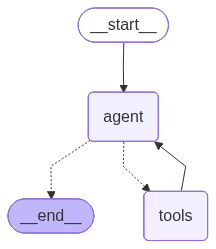

In [139]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Não foi possível visualizar o grafo: {e}")

## 6 - Interface de Coleta de Dados

### 6.1 - Criação do formulário

In [140]:
def create_form():
    idade = widgets.IntSlider(
        value=25,
        min=15,
        max=80,
        step=1,
        description='Idade (anos):',
        style={'description_width': 'initial'}
    )
    
    peso = widgets.FloatSlider(
        value=70.0,
        min=40.0,
        max=150.0,
        step=0.5,
        description='Peso (kg):',
        style={'description_width': 'initial'}
    )
    
    altura = widgets.FloatSlider(
        value=1.75,
        min=1.40,
        max=2.20,
        step=0.01,
        description='Altura (m):',
        style={'description_width': 'initial'}
    )
    
    sexo = widgets.Dropdown(
        options=['M', 'F'],
        description='Sexo:',
        value='M',
        style={'description_width': 'initial'}
    )
    
    periodicidade = widgets.IntSlider(
        value=4,
        min=2,
        max=6,
        step=1,
        description='Dias por semana:',
        style={'description_width': 'initial'}
    )
    
    objetivo = widgets.Dropdown(
        options=['hipertrofia', 'emagrecimento', 'força', 'condicionamento'],
        description='Objetivo:',
        value='hipertrofia',
        style={'description_width': 'initial'}
    )
    
    generate_btn = widgets.Button(
        description="Gerar Plano de Treino",
        button_style='success',
        icon='check'
    )
    
    output = widgets.Output()
    
    form_fields = {
        'idade': idade,
        'peso': peso,
        'altura': altura,
        'sexo': sexo,
        'periodicidade': periodicidade,
        'objetivo': objetivo,
        'generate_btn': generate_btn,
        'output': output
    }
    
    return form_fields

print("Formulário criado!")

Formulário criado!


### 6.2 - Função de exibição do formulário

In [141]:
def display_form(form):
    form_widget = widgets.VBox([
        widgets.HTML("<h2>AI Fitness Coach - Dados do Usuario</h2>"),
        form['idade'],
        form['peso'],
        form['altura'],
        form['sexo'],
        form['periodicidade'],
        form['objetivo'],
        form['generate_btn'],
        form['output']
    ])
    display(form_widget)

print("Função de exibição criada!")

Função de exibição criada!


## 7 - Geração do Plano de Treino

### 7.1 - Função de construção do prompt

In [142]:
def build_prompt(form_data):
    idade = form_data['idade']
    peso = form_data['peso']
    altura = form_data['altura']
    sexo = form_data['sexo']
    periodicidade = form_data['periodicidade']
    objetivo = form_data['objetivo']
    
    prompt = f"""
Você é um personal trainer especializado em musculação. Crie um plano de treino completo e detalhado com as seguintes especificações:

DADOS DO ALUNO:
- Idade: {idade} anos
- Peso: {peso} kg
- Altura: {altura} m
- Sexo: {sexo}
- Frequência: {periodicidade} dias por semana
- Objetivo: {objetivo}

INSTRUÇÕES:
1. Primeiro, use a ferramenta fitness_calculator para calcular o IMC e gasto calórico do aluno
2. Use a ferramenta knowledge_base_fitness para buscar informações sobre:
   - Princípios de treinamento para {objetivo}
   - Divisão de treino ideal para {periodicidade} dias por semana
   - Exercícios adequados para cada grupo muscular
3. Opcionalmente, use a ferramenta search_tool se precisar de informações atualizadas sobre técnicas específicas

ESTRUTURA DO PLANO (OBRIGATÓRIO):
Gere EXATAMENTE 12 treinos completos, seguindo a divisão adequada para {periodicidade} dias por semana.

Para cada um dos 12 treinos, forneça:
- Nome do treino (ex: Treino A - Peito e Tríceps)
- Lista de 4 a 6 exercícios
- Para cada exercício:
  * Nome do exercício
  * Séries e repetições (adaptadas ao objetivo {objetivo})
  * Tempo de descanso
  * Dica de execução ou músculo trabalhado

FORMATO DA RESPOSTA:
Organize o plano de forma clara e profissional, dividido em:
1. Análise Física (use os dados da ferramenta fitness_calculator)
2. Plano de Treino (12 treinos detalhados)
3. Orientações Gerais (aquecimento, progressão, recuperação)

Seja detalhado, profissional e garanta que o plano seja seguro e eficaz para o objetivo do aluno.
"""
    
    return prompt

print("Função de construção de prompt criada!")

Função de construção de prompt criada!


### 7.2 - Função de geração do plano

In [143]:
def generate_workout_plan(form_data, graph):
    prompt = build_prompt(form_data)
    
    config = {"configurable": {"thread_id": "workout_session"}}
    
    final_response = ""
    
    for event in graph.stream(
        {"messages": [("user", prompt)]},
        config
    ):
        for value in event.values():
            last_message = value["messages"][-1]
            if hasattr(last_message, 'content') and len(last_message.content) > 0:
                final_response = last_message.content
    
    return final_response

print("Função de geração do plano criada!")

Função de geração do plano criada!


### 7.3 - Função para formatar a resposta

In [144]:
def format_response(response):
    response = response.strip()
    if "</think>" in response:
        response = response.split("</think>")[-1].strip()
    return response

def show_response(response):
    display(Markdown(response))

print("Funções de formatação criadas!")

Funções de formatação criadas!


### 7.4 - Função principal de geração

In [145]:
def on_generate_clicked(b):
    form['output'].clear_output()
    
    with form['output']:
        print("Gerando plano de treino personalizado...")
        print("Isso pode levar alguns minutos...\n")
        
        form_data = {
            'idade': form['idade'].value,
            'peso': form['peso'].value,
            'altura': form['altura'].value,
            'sexo': form['sexo'].value,
            'periodicidade': form['periodicidade'].value,
            'objetivo': form['objetivo'].value
        }
        
        try:
            response = generate_workout_plan(form_data, graph)
            formatted_response = format_response(response)
            
            print("\n" + "="*80)
            print("PLANO DE TREINO GERADO COM SUCESSO")
            print("="*80 + "\n")
            
            show_response(formatted_response)
            
            global workout_plan_content
            workout_plan_content = formatted_response
            
        except Exception as e:
            print(f"Erro ao gerar plano de treino: {str(e)}")

print("Função principal criada!")

Função principal criada!


## 8 - Interface Completa

In [148]:
form = create_form()
form['generate_btn'].on_click(on_generate_clicked)
display_form(form)

### OPCIONAL: Se você atingiu o rate limit, execute esta célula para usar um modelo mais leve

In [ ]:
# Reconfigura para modelo mais leve (menos tokens)
print(" Trocando para modelo llama-3.1-8b-instant (mais rápido, consome menos tokens)...")

id_model = "llama-3.1-8b-instant"
temperature = 0.7

llm = load_llm(id_model, temperature)
llm_with_tools = llm.bind_tools(tools)

# Reconstrói o grafo com o novo modelo
graph = build_graph()

print(" Modelo mais leve configurado!")
print(" Agora você pode clicar em 'Gerar Plano de Treino' novamente")

### SOLUÇÃO PARA RATE LIMIT: Prompt Otimizado (usa menos tokens)

In [ ]:
def build_prompt_optimized(form_data):
    """Versão otimizada que consome menos tokens - gera plano mais conciso"""
    idade = form_data['idade']
    peso = form_data['peso']
    altura = form_data['altura']
    sexo = form_data['sexo']
    periodicidade = form_data['periodicidade']
    objetivo = form_data['objetivo']
    
    prompt = f"""Crie um plano de treino de musculação:

DADOS: {idade}anos, {peso}kg, {altura}m, sexo {sexo}, {periodicidade}x/semana, objetivo: {objetivo}

Use fitness_calculator e knowledge_base_fitness para criar 12 treinos.
Cada treino: nome, 4-6 exercícios (nome, séries x reps, descanso).
Formato: Análise Física + 12 Treinos + Orientações."""
    
    return prompt

def on_generate_clicked_optimized(b):
    """Versão otimizada que consome menos tokens"""
    form['output'].clear_output()
    
    with form['output']:
        print(" Gerando plano OTIMIZADO (menos tokens)...")
        print(" Aguarde...\n")
        
        form_data = {
            'idade': form['idade'].value,
            'peso': form['peso'].value,
            'altura': form['altura'].value,
            'sexo': form['sexo'].value,
            'periodicidade': form['periodicidade'].value,
            'objetivo': form['objetivo'].value
        }
        
        try:
            # Usa prompt otimizado
            prompt = build_prompt_optimized(form_data)
            config = {"configurable": {"thread_id": "workout_session"}}
            
            final_response = ""
            for event in graph.stream({"messages": [("user", prompt)]}, config):
                for value in event.values():
                    last_message = value["messages"][-1]
                    if hasattr(last_message, 'content') and len(last_message.content) > 0:
                        final_response = last_message.content
            
            formatted_response = format_response(final_response)
            
            print("\n" + "="*60)
            print(" PLANO GERADO COM SUCESSO")
            print("="*60 + "\n")
            
            show_response(formatted_response)
            
            global workout_plan_content
            workout_plan_content = formatted_response
            
        except Exception as e:
            error_msg = str(e)
            if "rate_limit" in error_msg.lower():
                print(" RATE LIMIT - Aguarde 2-5 minutos e tente novamente")
                print(" Ou tente usar outro modelo Groq se disponível")
            else:
                print(f" Erro: {error_msg}")

# Reconfigura o botão para usar a versão otimizada
form['generate_btn'].on_click(on_generate_clicked_optimized)

print("✅ Prompt otimizado configurado!")
print("💡 Agora clique em 'Gerar Plano de Treino' para usar versão que consome menos tokens")

### 9.2 - Loop de chat

In [ ]:
def run_chat():
    print("AI Fitness Coach - Modo Chat")
    print("Digite 'sair' ou 'q' para encerrar\n")
    print("="*50)
    
    start_msg = "Olá! Sou seu AI Fitness Coach. Posso ajudar você com dúvidas sobre treinos, exercícios, nutrição e criar planos personalizados. Como posso ajudar?"
    print(f"Coach: {start_msg}")
    
    while True:
        try:
            print("\n" + "="*50 + "\n")
            user_input = input("Você: ")
            
            if user_input.lower() in ["q", "sair", "exit"]:
                print("\nAté mais! Bons treinos!")
                break
            
            if user_input.strip():
                stream_graph_updates([("user", user_input)])
                
        except KeyboardInterrupt:
            print("\n\nChat interrompido. Até mais!")
            break
        except Exception as e:
            print(f"Erro: {str(e)}")
            break

# Descomente a linha abaixo para iniciar o modo chat
# run_chat()

## 10 - Testes e Exemplos

### 10.1 - Teste da ferramenta de cálculo

In [ ]:
# Teste do fitness_calculator
resultado = fitness_calculator.invoke({
    "idade": 25,
    "peso": 75.0,
    "altura": 1.75,
    "sexo": "M",
    "objetivo": "hipertrofia"
})

print("Teste da Ferramenta de Cálculo:")
print(resultado)

Teste da Ferramenta de Cálculo:

        Análise Física:
        - IMC: 24.5 (Peso normal)
        - Taxa Metabólica Basal: 1791 kcal/dia
        - Gasto calórico estimado por treino: 600 kcal
        - Intensidade recomendada: Moderada a alta

        Recomendações:
        - Hidratação: 2625ml de água por dia
        - Proteína diária: 135g
        


### 10.2 - Teste do retriever

In [ ]:
# Teste do retriever_tool
resultado = retriever_tool.invoke("exercícios para treino de peito para hipertrofia")

print("Teste da Ferramenta RAG:")
print(resultado[:500] + "...")

Teste da Ferramenta RAG:
# Princípios do Treinamento de Musculação

## Hipertrofia Muscular
A hipertrofia é o aumento do tamanho das fibras musculares. Para maximizar a hipertrofia:
- Volume: 3-5 séries por exercício
- Repetições: 8-12 repetições por série
- Descanso: 60-90 segundos entre séries
- Frequência: Treinar cada grupo muscular 2 vezes por semana
- Progressão: Aumentar carga gradualmente

## Força Muscular
Treinamento focado em ganho de força máxima:
- Volume: 3-5 séries por exercício
- Repetições: 3-6 repetiçõ...


### 10.3 - Teste completo com exemplo

In [ ]:
# Exemplo de dados para teste
exemplo_form_data = {
    'idade': 28,
    'peso': 80.0,
    'altura': 1.78,
    'sexo': 'M',
    'periodicidade': 4,
    'objetivo': 'hipertrofia'
}

print("Teste completo com dados de exemplo:")
print(f"Idade: {exemplo_form_data['idade']} anos")
print(f"Peso: {exemplo_form_data['peso']} kg")
print(f"Altura: {exemplo_form_data['altura']} m")
print(f"Periodicidade: {exemplo_form_data['periodicidade']} dias/semana")
print(f"Objetivo: {exemplo_form_data['objetivo']}")
print("\nDescomente as linhas abaixo para gerar o plano:\n")


#response = generate_workout_plan(exemplo_form_data, graph)
#show_response(format_response(response))

Teste completo com dados de exemplo:
Idade: 28 anos
Peso: 80.0 kg
Altura: 1.78 m
Periodicidade: 4 dias/semana
Objetivo: hipertrofia

Descomente as linhas abaixo para gerar o plano:



## 11 - Exportação (Opcional)

In [ ]:
def export_to_txt(content, filename="plano_treino.txt"):
    """Exporta o plano de treino para um arquivo de texto"""
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(content)
        print(f"Plano exportado com sucesso para: {filename}")
    except Exception as e:
        print(f"Erro ao exportar: {str(e)}")

# Exemplo de uso (após gerar um plano):
    #if 'workout_plan_content' in globals():
    #export_to_txt(workout_plan_content)

## Conclusão

Este notebook implementa um agente completo de IA para criação de planos de treino personalizados usando LangGraph.

### Funcionalidades Implementadas:

1. Coleta e validação de dados do usuário (idade, peso, altura, periodicidade, objetivo)
2. Ferramenta de cálculos matemáticos (IMC, gasto calórico, TMB)
3. Ferramenta de busca na web (Tavily Search) para informações atualizadas
4. Sistema RAG com base de conhecimento vetorizada no Pinecone
5. Geração de 12 treinos completos e detalhados
6. Interface interativa com formulário
7. Modo chat para dúvidas e interações

### Arquitetura LangGraph:

- Nó de agente principal
- Nó de ferramentas (tools)
- Transições condicionais entre agente e ferramentas
- Memória persistente para contexto de conversação

### Como Usar:

1. Execute todas as células na ordem
2. Preencha o formulário com seus dados
3. Clique em "Gerar Plano de Treino"
4. Aguarde a geração do plano completo
5. Opcionalmente, use o modo chat para tirar dúvidas

### Próximos Passos:

- Adicionar exportação para PDF
- Implementar acompanhamento de progresso
- Criar histórico de treinos
- Adicionar recomendações nutricionais detalhadas